# Monte Carlo Simulation for discretely monitored fixed strike arithmetic average Asian option using multiple variance reduction techniques (antithetic variate/control variate/quasi random number/importance sampling)

Scroll down to see comparisons for error reduction and computation time

In [ ]:
# Import dependencies
import time
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import qmc
from scipy.linalg import cholesky
from scipy.integrate import quad
from datetime import datetime
import matplotlib.pyplot as plt

## Analytic solution for discretely monitored fixed strike geometric average Asian option (http://dx.doi.org/10.4134/BKMS.b150283 Bara Kim et al)

In [ ]:
omega_table = {}

def a(s,w,S0,v0,theta,sigma,kappa,rho,r,t_n,T,kStar):
  n = len(t_n)

  summation = np.sum(t_n[kStar:])

  term1 = (s*(n-kStar)/n + w)*(np.log(S0) - rho*v0/sigma) # - r*t + rho*kappa*theta/sigma*t)
  term2 = (r-rho*kappa*theta/sigma)*(s/n*summation + w*T)
  return (term1+term2)

def omega(s,w,sigma,rho,k,kStar,n):
  if(k==kStar):
    return 0
  elif(k==n+1):
    return (rho*w/sigma)
  else:
    return (rho*s/(sigma*n))

def z(s,w,sigma,kappa,rho,k,n):
  return ((2*rho*kappa-sigma)*((n-k+1)*s+n*w)/(2*sigma*n) + (1-rho**2)*((n-k+1)*s+n*w)**2/(2*n**2))
z(1,1,0.02,0.01,0.1,6,5)

def F(z1,z2,tau,sigma,kappa):
  if(np.absolute(kappa**2-2.0*z1*sigma**2) < 1e-8):
    return (1.0 + 0.5*tau*(kappa-z2*sigma*sigma))
  else:
    temp = np.sqrt(kappa**2-2.0*z1*sigma**2)
    return (np.cosh(0.5*tau*temp) + (kappa-z2*sigma**2)*np.sinh(0.5*tau*temp)/temp)


def F_tilde(z1,z2,tau,sigma,kappa):
  temp = np.sqrt(kappa**2-2*z1*sigma**2)
  return (0.5*temp*np.sinh(0.5*tau*temp) + 0.5*(kappa-z2*sigma**2)*np.cosh(0.5*tau*temp))

def omega_tilde(s,w,sigma,kappa,rho,k,kStar,n,tauK):
  omega_k = omega(s,w,sigma,rho,k,kStar,n)
  if(k==n+1):
    return omega_k
  else:
    dTauK = tauK[k+1] - tauK[k]
    z_kp1 = z(s,w,sigma,kappa,rho,k+1,n)
    omega_kp1 = 0


    if (k+1) in omega_table:
      omega_kp1 = omega_table[k+1]
    else:
      omega_kp1 = omega_tilde(s,w,sigma,kappa,rho,k+1,kStar,n,tauK)

    ratio = F_tilde(z_kp1,omega_kp1,dTauK,sigma,kappa)/F(z_kp1,omega_kp1,dTauK,sigma,kappa)

    omega_table[k] = (omega_k + kappa/sigma**2 - 2*ratio/sigma**2)
    return (omega_k + kappa/sigma**2 - 2*ratio/sigma**2)

def psi_disc(s,w,S0,v0,theta,sigma,kappa,rho,r,t,T,kStar,t_n,tauK):

  omega_table.clear()

  n = len(t_n)
  aTerm = a(s,w,S0,v0,theta,sigma,kappa,rho,r,t_n,T,kStar)
  omegaTerm = v0*omega_tilde(s,w,sigma,kappa,rho,kStar,kStar,n,tauK)
  term3 = kappa**2*theta*(T-t)/(sigma**2)

  summation = 0.0
  for i in range(kStar+1,n+2):
    dTau = tauK[i] - tauK[i-1]
    z_k = z(s,w,sigma,kappa,rho,i,n)
    omega_tilde_k = omega_tilde(s,w,sigma,kappa,rho,i,kStar,n,tauK)

    summation += np.log(F(z_k,omega_tilde_k,dTau,sigma,kappa))

  term4 = 2*kappa*theta*summation/sigma**2

  return np.exp(aTerm + omegaTerm + term3 - term4)

def GeoIntegrand_disc(x,S0,v0,theta,sigma,kappa,rho,r,kStar,t_n,tauK,t,T,K):
  term1 = psi_disc(1.0+x*1j,0.0+0.0*1j,S0,v0,theta, sigma, kappa , rho, r, t , T , kStar, t_n, tauK) - K*psi_disc(0.0+x*1j,0.0+0.0*1j,S0,v0,theta, sigma, kappa , rho, r, t , T , kStar, t_n, tauK)
  return np.real(term1*np.exp(-x*1j*np.log(K))/(x*1j))

def GeoIntegral_disc(S0,v0,theta,sigma,kappa,rho,r,kStar,t_n,tauK,t,T,K):
  res, err = quad(GeoIntegrand_disc, 0, 25000, args=(S0,v0,theta,sigma,kappa,rho,r,kStar,t_n,tauK,t,T,K))
  print(err)
  return res

def DiscGeomAsianCall_disc(S0,v0,theta,sigma,kappa,rho,r,kStar,t_n,tauK,t,T,K):
  term1 = 0.5*(psi_disc(1.0+0.0*1j,0.0+0.0*1j,S0,v0,theta,sigma,kappa,rho,r,t,T,kStar,t_n,tauK) - K)
  term2 = 1/np.pi*GeoIntegral_disc(S0,v0,theta,sigma,kappa,rho,r,kStar,t_n,tauK,t,T,K)
  return np.exp(-r*(T-t))*(term1+term2)


## Analytic solution for continuously monitored fixed strike geometric average Asian option (https://doi.org/10.1080/14697688.2011.596844 Bara Kim & In-Suk Wee)

In [ ]:
def psi(s,w,S0,v0,theta,sigma,kappa,rho,r,n,T):
    s = s + 0j

    a1 = 2*v0/sigma**2
    a2 = 2*kappa*theta/sigma**2
    a3 = np.log(S0)+((r*sigma-kappa*theta*rho)*T)/(2*sigma)-(rho*v0)/sigma
    a4 = np.log(S0)-(rho*v0/sigma)+(r-rho*kappa*theta/sigma)*T
    a5 = (kappa*v0+kappa**2*theta*T)/(sigma**2)
    #print(a5)
    if(np.isscalar(s)):
      h_matrix = np.zeros((n+3, 1),dtype='complex128')
    else:
      h_matrix = np.zeros((n+3, np.size(s,0)),dtype='complex128') # might need np.size(s,1) not sure yet

    h_matrix[2] = 1
    h_matrix[3] = T*(kappa-w*rho*sigma)/2

    nmat = np.linspace(1,n,num=n)
    A1 = 1/(4*nmat[1:]*(nmat[1:]-1))
    A2 = -s**2*sigma**2*(1-rho**2)*T**2
    A3 = (s*sigma*T*(sigma-2*rho*kappa)-2*s*w*sigma**2*T*(1-rho**2))
    A4 = T*(kappa**2*T-2*s*rho*sigma-w*(2*rho*kappa-sigma)*sigma*T-w**2*(1-rho**2)*sigma**2*T)
    for k in range(4,(n+3)):
      h_matrix[k] = A1[k-4]*(A2*h_matrix[k-4]+A3*(T*h_matrix[k-3])+A4*h_matrix[k-2])

    H = np.sum(h_matrix[2:], axis=0)
    h_tilde = np.transpose(np.transpose(h_matrix[3:])*nmat/T)
    H_tilde = np.sum(h_tilde,axis=0)
    return np.exp(-a1*(H_tilde/H)-a2*np.log(H)+a3*s+a4*w+a5)

def GeoIntegrand(x,S0,v0,theta,sigma,kappa,rho,r,n,T,K):
  A = psi(1+x*1j, 0 ,S0, v0, theta, sigma, kappa, rho, r, n, T)
  B = psi(0+x*1j, 0, S0, v0, theta, sigma, kappa, rho, r, n, T)
  C = np.exp(-1j*x*np.log(K))/(1j*x)
  return np.real((A-K*B)*C)

def GeoIntegral(S0,v0,theta,sigma,kappa,rho,r,n,T,K):
  res, err = quad(GeoIntegrand, 0, 25000, args=(S0,v0,theta,sigma,kappa,rho,r,n,T,K))
  print(err)
  return res

def GeomAsianCall(S0,v0,theta,sigma,kappa,rho,r,n,T,K):
  return np.exp(-r*T)*((psi(1,0,S0,v0,theta,sigma,kappa,rho,r,n,T)-K)*0.5+1/np.pi*GeoIntegral(S0,v0,theta,sigma,kappa,rho,r,n,T,K))

# Input parameters for Heston Model and Asian Option details

no timesteps before averaging implemented yet;
no difference between timestep and monitoring step implemented yet;
easy to generalize

In [ ]:
# Initialise parameters
S0 = 100.0     # initial stock price
K = 100.0        # strike price
T = 0.25        # time to maturity in years
r = 0.15       # annual risk-free rate
vol = 0.4     # volatility (%)
div = 0.00     # continuous dividend yield (not yet implemented)

# Heston parameters
kappa = 2.0
vt0 = vol**2    # variance
theta = 0.4 # long-run average
sigma = 0.5 # vol of vol
rho_scalar = -0.3 # correlation return and vol process
rho = np.array([[1,rho_scalar**(1)],
                [rho_scalar**(1),1]])

N_tot = 52    # discrete time steps
N_avg = N_tot # timesteps during averaging
N_pre = 0 # timesteps before averaging (not yet implemented)
P = 17
M = 2**P   # number of simulations (multiple of 2 for quasi random number properties)

# Calculated analytic solution for discretely monitored fixed strike geometric average Asian option

In [ ]:
t_n = np.full(shape=(N_avg), fill_value=0.0)
for i in range(1,N_avg+1):
  t_n[i-1] = 1.0*T*i/N_avg
tauK = np.full(shape=(N_avg+2), fill_value=0.0)
for i in range(1,N_avg+1):
  tauK[i] = t_n[i-1]
tauK[N_avg+1] = T

DiscGeomAsianCall_disc(S0,vt0,theta,sigma,kappa,rho_scalar,r,0,t_n,tauK,0,T,K)

1.9654967915727628e-07


(5.650967851654385+0j)

### Calculated analytic solution for continuously monitored fixed strike geometric average Asian option

In [ ]:
GeomAsianCall(S0,vt0,theta,sigma,kappa,rho_scalar,r,40,T,K)

8.705086707028187e-09


array([5.55966794+0.j])

# Simple Monte Carlo simulation for discretely monitored fixed strike arithmetic average Asian option



In [ ]:
# Start Timer
start_time = time.time()

# Precompute constants
dt = T/N_tot

# Heston model adjustments for time steps
kappadt = kappa*dt
sigmasdt = sigma*np.sqrt(dt)

# Perform (lower) cholesky decomposition
lower_chol = cholesky(rho, lower=True)

# Generate Wiener variables
Z = np.random.normal(size=(N_tot+1,M,2))
W_ind = np.random.normal(size=(N_tot+1,M,1))
#W = Z @ lower_chol
W = rho_scalar*Z[:,:,0] + np.sqrt(1-rho_scalar**2)*Z[:,:,1]
# arrays for storing prices and variances
St = np.full(shape=(N_tot+1,M), fill_value=S0)
vt = np.full(shape=(N_tot+1,M), fill_value=vt0)

# array for storing maximum's
AT_sum = np.full(shape=(M), fill_value=0.0)
GT_sum = np.full(shape=(M), fill_value=1.0)
finval = np.full(shape=(M), fill_value=1.0)



for j in range(N_pre+1,N_tot+1):

    # Simulate variance processes
    vt[j] = np.maximum(vt[j-1] + kappadt*(theta - vt[j-1]) + sigmasdt*np.sqrt(vt[j-1])*Z[j-1,:,0],0)

    # Simulate log asset prices
    nudt = (r - div - 0.5*vt[j-1])*dt
    #St[j] = St[j-1]*np.exp( nudt + np.sqrt(vt[j-1]*dt)*W[j-1,:,1] )
    St[j] = St[j-1]*np.exp( nudt + np.sqrt(vt[j-1]*dt)*W[j-1,:] )

    AT_sum += St[j]
    GT_sum = GT_sum*(St[j]**(1/N_avg))
    finval = St[j]

#for j in range(1,N_tot+1):

#    # Simulate variance processes
#    vt[j] = vt[j-1] + kappadt*(theta - vt[j-1]) + sigmasdt*np.sqrt(vt[j-1])*W[j-1,:,0]

#    # Simulate log asset prices
#    nudt = (r - div - 0.5*vt[j])*dt
#    St[j] = St[j-1]*np.exp( nudt + np.sqrt(vt[j]*dt)*W[j-1,:,1] )

#    AT_sum += St[j]


# Compute Expectation and SE
#AT_sum = AT_sum/N_tot
AT_sum = AT_sum/N_avg
GT_sum = GT_sum
CT = np.maximum(0, AT_sum - K)
CT_geom = np.maximum(0, GT_sum - K)
CT_call = np.maximum(0, finval - K)

C0_fast = np.exp(-r*T)*np.sum(CT)/M
C0_fast_geom = np.exp(-r*T)*np.sum(CT_geom)/M
C0_fast_call = np.exp(-r*T)*np.sum(CT_call)/M

SE_fast = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_fast)**2) / (M-1) ) /np.sqrt(M)
SE_fast_geom = np.sqrt( np.sum( (np.exp(-r*T)*CT_geom - C0_fast_geom)**2) / (M-1) ) /np.sqrt(M)
SE_fast_call = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_fast_call)**2) / (M-1) ) /np.sqrt(M)

time_comp_fast = round(time.time() - start_time,4)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_fast,3),np.round(SE_fast,3)))
print("Computation time is: ", time_comp_fast)
print("Geom Call value is ${0} with SE +/- {1}".format(np.round(C0_fast_geom,3),np.round(SE_fast_geom,3)))
print("Normal Call value is ${0} with SE +/- {1}".format(np.round(C0_fast_call,3),np.round(SE_fast_call,3)))

Call value is $5.905 with SE +/- 0.023
Computation time is:  1.1622
Geom Call value is $5.653 with SE +/- 0.022
Normal Call value is $10.891 with SE +/- 0.027


### Quasi number generators

In [ ]:
def sobol(m, d=1):
    sampler = qmc.Sobol(d, scramble=True)
    return sampler.random_base2(m)

def sobol_norm(m, d=1):
    sampler = qmc.Sobol(d, scramble=True)
    x_sobol = sampler.random_base2(m)
    return norm.ppf(x_sobol)

## Simple Monte Carlo simulation for discretely monitored fixed strike arithmetic average Asian option with quasi random numbers


In [ ]:


# Start Timer
start_time = time.time()

# Precompute constants
dt = T/N_tot

# Heston model adjustments for time steps
kappadt = kappa*dt
sigmasdt = sigma*np.sqrt(dt)

# Perform (lower) cholesky decomposition
lower_chol = cholesky(rho, lower=True)

# Generate Wiener variables
Z1 = sobol_norm(m=P, d=N_tot+1).T
Z2 = sobol_norm(m=P, d=N_tot+1).T
#W = Z @ lower_chol
W = rho_scalar*Z1 + np.sqrt(1-rho_scalar**2)*Z2
# arrays for storing prices and variances
St = np.full(shape=(N_tot+1,M), fill_value=S0)
vt = np.full(shape=(N_tot+1,M), fill_value=vt0)

# array for storing maximum's
AT_sum = np.full(shape=(M), fill_value=0.0)
GT_sum = np.full(shape=(M), fill_value=1.0)
finval = np.full(shape=(M), fill_value=1.0)



for j in range(N_pre+1,N_tot+1):

    # Simulate variance processes
    vt[j] = np.maximum(vt[j-1] + kappadt*(theta - vt[j-1]) + sigmasdt*np.sqrt(vt[j-1])*Z1[j-1,:],0)

    # Simulate log asset prices
    nudt = (r - div - 0.5*vt[j-1])*dt
    #St[j] = St[j-1]*np.exp( nudt + np.sqrt(vt[j-1]*dt)*W[j-1,:,1] )
    St[j] = St[j-1]*np.exp( nudt + np.sqrt(vt[j-1]*dt)*W[j-1,:] )

    AT_sum += St[j]
    GT_sum = GT_sum*(St[j]**(1/N_avg))
    finval = St[j]

#for j in range(1,N_tot+1):

#    # Simulate variance processes
#    vt[j] = vt[j-1] + kappadt*(theta - vt[j-1]) + sigmasdt*np.sqrt(vt[j-1])*W[j-1,:,0]

#    # Simulate log asset prices
#    nudt = (r - div - 0.5*vt[j])*dt
#    St[j] = St[j-1]*np.exp( nudt + np.sqrt(vt[j]*dt)*W[j-1,:,1] )

#    AT_sum += St[j]


# Compute Expectation and SE
#AT_sum = AT_sum/N_tot
AT_sum = AT_sum/N_avg
GT_sum = GT_sum
CT = np.maximum(0, AT_sum - K)
CT_geom = np.maximum(0, GT_sum - K)
CT_call = np.maximum(0, finval - K)

C0_fast = np.exp(-r*T)*np.sum(CT)/M
C0_fast_geom = np.exp(-r*T)*np.sum(CT_geom)/M
C0_fast_call = np.exp(-r*T)*np.sum(CT_call)/M

SE_fast = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_fast)**2) / (M-1) ) /np.sqrt(M)
SE_fast_geom = np.sqrt( np.sum( (np.exp(-r*T)*CT_geom - C0_fast_geom)**2) / (M-1) ) /np.sqrt(M)
SE_fast_call = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_fast_call)**2) / (M-1) ) /np.sqrt(M)

time_comp_fast = round(time.time() - start_time,4)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_fast,3),np.round(SE_fast,3)))
print("Computation time is: ", time_comp_fast)
print("Geom Call value is ${0} with SE +/- {1}".format(np.round(C0_fast_geom,3),np.round(SE_fast_geom,3)))
print("Normal Call value is ${0} with SE +/- {1}".format(np.round(C0_fast_call,3),np.round(SE_fast_call,3)))

Call value is $6.225 with SE +/- 0.024
Computation time is:  1.6496
Geom Call value is $5.959 with SE +/- 0.023
Normal Call value is $11.255 with SE +/- 0.028


# Simple Monte Carlo simulation with antithetic variable for underlying

In [ ]:
# Start Timer
start_time = time.time()

# Precompute constants
dt = T/N_tot

# Heston model adjustments for time steps
kappadt = kappa*dt
sigmasdt = sigma*np.sqrt(dt)

# Perform (lower) cholesky decomposition
lower_chol = cholesky(rho, lower=True)

# Generate Wiener variables
Z = np.random.normal(size=(N_tot+1,M,2))
#W_ind = np.random.normal(size=(N_tot+1,M,1))
#W = Z @ lower_chol
W1 = rho_scalar*Z[:,:,0] + np.sqrt(1-rho_scalar**2)*Z[:,:,1]
W2 = rho_scalar*Z[:,:,0] - np.sqrt(1-rho_scalar**2)*Z[:,:,1]
# arrays for storing prices and variances
St1 = np.full(shape=(N_tot+1,M), fill_value=S0)
St2 = np.full(shape=(N_tot+1,M), fill_value=S0)
vt = np.full(shape=(N_tot+1,M), fill_value=vt0)

# array for storing maximum's
AT1_sum = np.full(shape=(M), fill_value=0.0)
AT2_sum = np.full(shape=(M), fill_value=0.0)
GT1_sum = np.full(shape=(M), fill_value=1.0)
GT2_sum = np.full(shape=(M), fill_value=1.0)
finval1 = np.full(shape=(M), fill_value=1.0)
finval2 = np.full(shape=(M), fill_value=1.0)



for j in range(N_pre+1,N_tot+1):

    # Simulate variance processes
    vt[j] = np.maximum(vt[j-1] + kappadt*(theta - vt[j-1]) + sigmasdt*np.sqrt(vt[j-1])*Z[j-1,:,0],0)

    # Simulate log asset prices
    nudt = (r - div - 0.5*vt[j-1])*dt
    St1[j] = St1[j-1]*np.exp( nudt + np.sqrt(vt[j-1]*dt)*W1[j-1,:] )
    St2[j] = St2[j-1]*np.exp( nudt + np.sqrt(vt[j-1]*dt)*W2[j-1,:] )

    AT1_sum += St1[j]
    AT2_sum += St2[j]
    GT1_sum = GT1_sum*(St1[j]**(1/N_avg))
    GT2_sum = GT2_sum*(St2[j]**(1/N_avg))
    finval1 = St1[j]
    finval2 = St2[j]

#for j in range(1,N_tot+1):

#    # Simulate variance processes
#    vt[j] = vt[j-1] + kappadt*(theta - vt[j-1]) + sigmasdt*np.sqrt(vt[j-1])*W[j-1,:,0]

#    # Simulate log asset prices
#    nudt = (r - div - 0.5*vt[j])*dt
#    St[j] = St[j-1]*np.exp( nudt + np.sqrt(vt[j]*dt)*W[j-1,:,1] )

#    AT_sum += St[j]


# Compute Expectation and SE
#AT_sum = AT_sum/N_tot
AT1_sum = AT1_sum/N_avg
AT2_sum = AT2_sum/N_avg
GT1_sum = GT1_sum
GT2_sum = GT2_sum
CT = 0.5*(np.maximum(0, AT1_sum - K) + np.maximum(0, AT2_sum - K))
CT_geom = 0.5*(np.maximum(0, GT1_sum - K) + np.maximum(0, GT2_sum - K))
CT_call = 0.5*(np.maximum(0, finval1 - K) + np.maximum(0, finval2 - K))

C0_av = np.exp(-r*T)*np.sum(CT)/M
C0_fast_geom = np.exp(-r*T)*np.sum(CT_geom)/M
C0_fast_call = np.exp(-r*T)*np.sum(CT_call)/M

SE_av = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_av)**2) / (M-1) ) /np.sqrt(M)
SE_fast_geom = np.sqrt( np.sum( (np.exp(-r*T)*CT_geom - C0_fast_geom)**2) / (M-1) ) /np.sqrt(M)
SE_fast_call = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_fast_call)**2) / (M-1) ) /np.sqrt(M)

time_comp_av = round(time.time() - start_time,4)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_av,3),np.round(SE_av,3)))
print("Computation time is: ", time_comp_av)
print("Geom Call value is ${0} with SE +/- {1}".format(np.round(C0_fast_geom,3),np.round(SE_fast_geom,3)))
print("Normal Call value is ${0} with SE +/- {1}".format(np.round(C0_fast_call,3),np.round(SE_fast_call,3)))

Call value is $5.897 with SE +/- 0.012
Computation time is:  1.548
Geom Call value is $5.645 with SE +/- 0.012
Normal Call value is $10.868 with SE +/- 0.018


# Simple Monte Carlo simulation with antithetic variate for underlying and variance

In [ ]:
# Start Timer
start_time = time.time()

# Precompute constants
dt = T/N_tot

# Heston model adjustments for time steps
kappadt = kappa*dt
sigmasdt = sigma*np.sqrt(dt)

# Perform (lower) cholesky decomposition
lower_chol = cholesky(rho, lower=True)

# Generate Wiener variables
Z = np.random.normal(size=(N_tot+1,M,2))
W_ind = np.random.normal(size=(N_tot+1,M,1))
#W = Z @ lower_chol
W11 = rho_scalar*Z[:,:,0] + np.sqrt(1-rho_scalar**2)*Z[:,:,1]
W21 = rho_scalar*Z[:,:,0] - np.sqrt(1-rho_scalar**2)*Z[:,:,1]
W12 = -rho_scalar*Z[:,:,0] + np.sqrt(1-rho_scalar**2)*Z[:,:,1]
W22 = -rho_scalar*Z[:,:,0] - np.sqrt(1-rho_scalar**2)*Z[:,:,1]
# arrays for storing prices and variances
St11 = np.full(shape=(N_tot+1,M), fill_value=S0)
St21 = np.full(shape=(N_tot+1,M), fill_value=S0)
St12 = np.full(shape=(N_tot+1,M), fill_value=S0)
St22 = np.full(shape=(N_tot+1,M), fill_value=S0)
vt1 = np.full(shape=(N_tot+1,M), fill_value=vt0)
vt2 = np.full(shape=(N_tot+1,M), fill_value=vt0)

# array for storing maximum's
AT1_sum = np.full(shape=(M), fill_value=0.0)
AT2_sum = np.full(shape=(M), fill_value=0.0)
AT3_sum = np.full(shape=(M), fill_value=0.0)
AT4_sum = np.full(shape=(M), fill_value=0.0)
GT1_sum = np.full(shape=(M), fill_value=1.0)
GT2_sum = np.full(shape=(M), fill_value=1.0)
GT3_sum = np.full(shape=(M), fill_value=1.0)
GT4_sum = np.full(shape=(M), fill_value=1.0)
finval1 = np.full(shape=(M), fill_value=1.0)
finval2 = np.full(shape=(M), fill_value=1.0)
finval3 = np.full(shape=(M), fill_value=1.0)
finval4 = np.full(shape=(M), fill_value=1.0)



for j in range(N_pre+1,N_tot+1):

    # Simulate variance processes
    vt1[j] = np.maximum(vt1[j-1] + kappadt*(theta - vt1[j-1]) + sigmasdt*np.sqrt(vt1[j-1])*Z[j-1,:,0],0)
    vt2[j] = np.maximum(vt2[j-1] + kappadt*(theta - vt2[j-1]) - sigmasdt*np.sqrt(vt2[j-1])*Z[j-1,:,0],0)

    # Simulate log asset prices
    nudt1 = (r - div - 0.5*vt1[j-1])*dt
    nudt2 = (r - div - 0.5*vt2[j-1])*dt
    St11[j] = St11[j-1]*np.exp( nudt1 + np.sqrt(vt1[j-1]*dt)*W11[j-1,:] )
    St21[j] = St21[j-1]*np.exp( nudt1 + np.sqrt(vt1[j-1]*dt)*W21[j-1,:] )

    St12[j] = St12[j-1]*np.exp( nudt2 + np.sqrt(vt2[j-1]*dt)*W12[j-1,:] )
    St22[j] = St22[j-1]*np.exp( nudt2 + np.sqrt(vt2[j-1]*dt)*W22[j-1,:] )

    AT1_sum += St11[j]
    AT2_sum += St21[j]
    AT3_sum += St12[j]
    AT4_sum += St22[j]
    GT1_sum = GT1_sum*(St11[j]**(1/N_avg))
    GT2_sum = GT2_sum*(St21[j]**(1/N_avg))
    GT3_sum = GT3_sum*(St12[j]**(1/N_avg))
    GT4_sum = GT4_sum*(St22[j]**(1/N_avg))
    finval1 = St11[j]
    finval2 = St21[j]
    finval3 = St21[j]
    finval4 = St22[j]

#for j in range(1,N_tot+1):

#    # Simulate variance processes
#    vt[j] = vt[j-1] + kappadt*(theta - vt[j-1]) + sigmasdt*np.sqrt(vt[j-1])*W[j-1,:,0]

#    # Simulate log asset prices
#    nudt = (r - div - 0.5*vt[j])*dt
#    St[j] = St[j-1]*np.exp( nudt + np.sqrt(vt[j]*dt)*W[j-1,:,1] )

#    AT_sum += St[j]


# Compute Expectation and SE
#AT_sum = AT_sum/N_tot
AT1_sum = AT1_sum/N_avg
AT2_sum = AT2_sum/N_avg
AT3_sum = AT3_sum/N_avg
AT4_sum = AT4_sum/N_avg
GT1_sum = GT1_sum
GT2_sum = GT2_sum
GT3_sum = GT3_sum
GT4_sum = GT4_sum
CT = 0.25*(np.maximum(0, AT1_sum - K) + np.maximum(0, AT2_sum - K) + np.maximum(0, AT3_sum - K) + np.maximum(0, AT4_sum - K))
CT_geom = 0.25*(np.maximum(0, GT1_sum - K) + np.maximum(0, GT2_sum - K) + np.maximum(0, GT3_sum - K) + np.maximum(0, GT4_sum - K))
CT_call = 0.25*(np.maximum(0, finval1 - K) + np.maximum(0, finval2 - K) + np.maximum(0, finval3 - K) + np.maximum(0, finval4 - K))

C0_av_dbl = np.exp(-r*T)*np.sum(CT)/M
C0_fast_geom = np.exp(-r*T)*np.sum(CT_geom)/M
C0_fast_call = np.exp(-r*T)*np.sum(CT_call)/M

SE_av_dbl = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_av_dbl)**2) / (M-1) ) /np.sqrt(M)
SE_fast_geom = np.sqrt( np.sum( (np.exp(-r*T)*CT_geom - C0_fast_geom)**2) / (M-1) ) /np.sqrt(M)
SE_fast_call = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_fast_call)**2) / (M-1) ) /np.sqrt(M)

time_comp_av_dbl = round(time.time() - start_time,4)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_av_dbl,3),np.round(SE_av_dbl,3)))
print("Computation time is: ", time_comp_av_dbl)
print("Geom Call value is ${0} with SE +/- {1}".format(np.round(C0_fast_geom,3),np.round(SE_fast_geom,3)))
print("Normal Call value is ${0} with SE +/- {1}".format(np.round(C0_fast_call,3),np.round(SE_fast_call,3)))

Call value is $5.902 with SE +/- 0.011
Computation time is:  2.6731
Geom Call value is $5.651 with SE +/- 0.01
Normal Call value is $10.857 with SE +/- 0.017


# Simple Monte Carlo simulation with static hedge using the discretely monitored fixed strike geometric average Asian option as a control variate

In [ ]:
# Start Timer
start_time = time.time()

# Precompute constants
dt = T/N_tot

# Heston model adjustments for time steps
kappadt = kappa*dt
sigmasdt = sigma*np.sqrt(dt)

# Perform (lower) cholesky decomposition
lower_chol = cholesky(rho, lower=True)


Z = np.random.normal(size=(N_tot+1,M,2))
W_ind = np.random.normal(size=(N_tot+1,M,1))
#W = Z @ lower_chol
W = rho_scalar*Z[:,:,0] + np.sqrt(1-rho_scalar**2)*Z[:,:,1]

# arrays for storing prices and variances
St = np.full(shape=(N_tot+1,M), fill_value=S0)
vt = np.full(shape=(N_tot+1,M), fill_value=vt0)

# array for storing maximum's
AT_sum = np.full(shape=(M), fill_value=0.0)
GT_sum = np.full(shape=(M), fill_value=1.0)
finval = np.full(shape=(M), fill_value=1.0)



for j in range(N_pre+1,N_tot+1):

    # Simulate variance processes
    vt[j] = np.maximum(vt[j-1] + kappadt*(theta - vt[j-1]) + sigmasdt*np.sqrt(vt[j-1])*Z[j-1,:,0],0)

    # Simulate log asset prices
    nudt = (r - div - 0.5*vt[j-1])*dt
    St[j] = St[j-1]*np.exp( nudt + np.sqrt(vt[j-1]*dt)*W[j-1,:] )

    AT_sum += St[j]
    GT_sum = GT_sum*(St[j]**(1/N_avg))
    finval = St[j]

#for j in range(1,N_tot+1):

#    # Simulate variance processes
#    vt[j] = vt[j-1] + kappadt*(theta - vt[j-1]) + sigmasdt*np.sqrt(vt[j-1])*W[j-1,:,0]

#    # Simulate log asset prices
#    nudt = (r - div - 0.5*vt[j])*dt
#    St[j] = St[j-1]*np.exp( nudt + np.sqrt(vt[j]*dt)*W[j-1,:,1] )

#    AT_sum += St[j]


# Compute Expectation and SE
#AT_sum = AT_sum/N_tot
AT_sum = AT_sum/N_avg
GT_sum = GT_sum
CT = np.maximum(0, AT_sum - K) - 1.0*np.maximum(0, GT_sum - K)
CT_geom = np.maximum(0, GT_sum - K)
CT_call = np.maximum(0, finval - K)

C0_cv = np.exp(-r*T)*np.sum(CT)/M
C0_fast_geom = np.exp(-r*T)*np.sum(CT_geom)/M
C0_fast_call = np.exp(-r*T)*np.sum(CT_call)/M

SE_cv = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_cv)**2) / (M-1) ) /np.sqrt(M)
SE_fast_geom = np.sqrt( np.sum( (np.exp(-r*T)*CT_geom - C0_fast_geom)**2) / (M-1) ) /np.sqrt(M)
SE_fast_call = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_fast_call)**2) / (M-1) ) /np.sqrt(M)

C0_cv = C0_cv + 1.0*DiscGeomAsianCall_disc(S0,vt0,theta,sigma,kappa,rho_scalar,r,0,t_n,tauK,0,T,K).real

time_comp_cv = round(time.time() - start_time,4)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_cv,3),np.round(SE_cv,3)))
print("Computation time is: ", time_comp_cv)
print("Geom Call value is ${0} with SE +/- {1}".format(np.round(C0_fast_geom,3),np.round(SE_fast_geom,3)))
print("Normal Call value is ${0} with SE +/- {1}".format(np.round(C0_fast_call,3),np.round(SE_fast_call,3)))

1.9654967915727628e-07
Call value is $5.904 with SE +/- 0.001
Computation time is:  3.9774
Geom Call value is $5.639 with SE +/- 0.022
Normal Call value is $10.886 with SE +/- 0.029


# Simple Monte Carlo simulation with static hedge using the discretely monitored fixed strike geometric average Asian option as a control variate and with antithetic for underlying

In [ ]:
# Start Timer
start_time = time.time()

# Precompute constants
dt = T/N_tot

# Heston model adjustments for time steps
kappadt = kappa*dt
sigmasdt = sigma*np.sqrt(dt)

# Perform (lower) cholesky decomposition
lower_chol = cholesky(rho, lower=True)

# Generate Wiener variables
Z = np.random.normal(size=(N_tot+1,M,2))
#W_ind = np.random.normal(size=(N_tot+1,M,1))
#W = Z @ lower_chol
W1 = rho_scalar*Z[:,:,0] + np.sqrt(1-rho_scalar**2)*Z[:,:,1]
W2 = rho_scalar*Z[:,:,0] - np.sqrt(1-rho_scalar**2)*Z[:,:,1]
# arrays for storing prices and variances
St1 = np.full(shape=(N_tot+1,M), fill_value=S0)
St2 = np.full(shape=(N_tot+1,M), fill_value=S0)
vt = np.full(shape=(N_tot+1,M), fill_value=vt0)

# array for storing maximum's
AT1_sum = np.full(shape=(M), fill_value=0.0)
AT2_sum = np.full(shape=(M), fill_value=0.0)
GT1_sum = np.full(shape=(M), fill_value=1.0)
GT2_sum = np.full(shape=(M), fill_value=1.0)
finval = np.full(shape=(M), fill_value=1.0)



for j in range(N_pre+1,N_tot+1):

    # Simulate variance processes
    vt[j] = np.maximum(vt[j-1] + kappadt*(theta - vt[j-1]) + sigmasdt*np.sqrt(vt[j-1])*Z[j-1,:,0],0)

    # Simulate log asset prices
    nudt = (r - div - 0.5*vt[j-1])*dt
    St1[j] = St1[j-1]*np.exp( nudt + np.sqrt(vt[j-1]*dt)*W1[j-1,:] )
    St2[j] = St2[j-1]*np.exp( nudt + np.sqrt(vt[j-1]*dt)*W2[j-1,:] )

    AT1_sum += St1[j]
    AT2_sum += St2[j]
    GT1_sum = GT1_sum*(St1[j]**(1/N_avg))
    GT2_sum = GT2_sum*(St2[j]**(1/N_avg))
    finval = St1[j]

#for j in range(1,N_tot+1):

#    # Simulate variance processes
#    vt[j] = vt[j-1] + kappadt*(theta - vt[j-1]) + sigmasdt*np.sqrt(vt[j-1])*W[j-1,:,0]

#    # Simulate log asset prices
#    nudt = (r - div - 0.5*vt[j])*dt
#    St[j] = St[j-1]*np.exp( nudt + np.sqrt(vt[j]*dt)*W[j-1,:,1] )

#    AT_sum += St[j]


# Compute Expectation and SE
#AT_sum = AT_sum/N_tot
AT1_sum = AT1_sum/N_avg
AT2_sum = AT2_sum/N_avg
GT1_sum = GT1_sum
GT2_sum = GT2_sum
CT = 0.5*(np.maximum(0, AT1_sum - K) - np.maximum(0, GT1_sum - K) + np.maximum(0, AT2_sum - K) - np.maximum(0, GT2_sum - K))
CT_geom = 0.5*(np.maximum(0, GT1_sum - K) + np.maximum(0, GT2_sum - K))
CT_call = np.maximum(0, finval - K)

C0_av_cv = np.exp(-r*T)*np.sum(CT)/M
C0_fast_geom = np.exp(-r*T)*np.sum(CT_geom)/M
C0_fast_call = np.exp(-r*T)*np.sum(CT_call)/M

SE_av_cv = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_av_cv)**2) / (M-1) ) /np.sqrt(M)
SE_fast_geom = np.sqrt( np.sum( (np.exp(-r*T)*CT_geom - C0_fast_geom)**2) / (M-1) ) /np.sqrt(M)
SE_fast_call = np.sqrt( np.sum( (np.exp(-r*T)*CT_call - C0_fast_call)**2) / (M-1) ) /np.sqrt(M)

C0_av_cv = C0_av_cv + 1.0*DiscGeomAsianCall_disc(S0,vt0,theta,sigma,kappa,rho_scalar,r,0,t_n,tauK,0,T,K).real

time_comp_av_cv = round(time.time() - start_time,4)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_av_cv,3),np.round(SE_av_cv,3)))
print("Computation time is: ", time_comp_av_cv)
print("Geom Call value is ${0} with SE +/- {1}".format(np.round(C0_fast_geom,3),np.round(SE_fast_geom,3)))
print("Normal Call value is ${0} with SE +/- {1}".format(np.round(C0_fast_call,3),np.round(SE_fast_call,3)))

1.9654967915727628e-07
Call value is $5.901 with SE +/- 0.001
Computation time is:  3.5062
Geom Call value is $5.63 with SE +/- 0.012
Normal Call value is $10.86 with SE +/- 0.044


# Simple Monte Carlo simulation with static hedge using the discretely monitored fixed strike geometric average Asian option as a control variate and with antithetic for underlying and volatility

In [ ]:
# Start Timer
start_time = time.time()

# Precompute constants
dt = T/N_tot

# Heston model adjustments for time steps
kappadt = kappa*dt
sigmasdt = sigma*np.sqrt(dt)

# Perform (lower) cholesky decomposition
lower_chol = cholesky(rho, lower=True)

# Generate Wiener variables
Z = np.random.normal(size=(N_tot+1,M,2))
W_ind = np.random.normal(size=(N_tot+1,M,1))
#W = Z @ lower_chol
W11 = rho_scalar*Z[:,:,0] + np.sqrt(1-rho_scalar**2)*Z[:,:,1]
W21 = rho_scalar*Z[:,:,0] - np.sqrt(1-rho_scalar**2)*Z[:,:,1]
W12 = -rho_scalar*Z[:,:,0] + np.sqrt(1-rho_scalar**2)*Z[:,:,1]
W22 = -rho_scalar*Z[:,:,0] - np.sqrt(1-rho_scalar**2)*Z[:,:,1]
# arrays for storing prices and variances
St11 = np.full(shape=(N_tot+1,M), fill_value=S0)
St21 = np.full(shape=(N_tot+1,M), fill_value=S0)
St12 = np.full(shape=(N_tot+1,M), fill_value=S0)
St22 = np.full(shape=(N_tot+1,M), fill_value=S0)
vt1 = np.full(shape=(N_tot+1,M), fill_value=vt0)
vt2 = np.full(shape=(N_tot+1,M), fill_value=vt0)

# array for storing maximum's
AT1_sum = np.full(shape=(M), fill_value=0.0)
AT2_sum = np.full(shape=(M), fill_value=0.0)
AT3_sum = np.full(shape=(M), fill_value=0.0)
AT4_sum = np.full(shape=(M), fill_value=0.0)
GT1_sum = np.full(shape=(M), fill_value=1.0)
GT2_sum = np.full(shape=(M), fill_value=1.0)
GT3_sum = np.full(shape=(M), fill_value=1.0)
GT4_sum = np.full(shape=(M), fill_value=1.0)
finval1 = np.full(shape=(M), fill_value=1.0)
finval2 = np.full(shape=(M), fill_value=1.0)
finval3 = np.full(shape=(M), fill_value=1.0)
finval4 = np.full(shape=(M), fill_value=1.0)



for j in range(N_pre+1,N_tot+1):

    # Simulate variance processes
    vt1[j] = np.maximum(vt1[j-1] + kappadt*(theta - vt1[j-1]) + sigmasdt*np.sqrt(vt1[j-1])*Z[j-1,:,0],0)
    vt2[j] = np.maximum(vt2[j-1] + kappadt*(theta - vt2[j-1]) - sigmasdt*np.sqrt(vt2[j-1])*Z[j-1,:,0],0)

    # Simulate log asset prices
    nudt1 = (r - div - 0.5*vt1[j-1])*dt
    nudt2 = (r - div - 0.5*vt2[j-1])*dt
    St11[j] = St11[j-1]*np.exp( nudt1 + np.sqrt(vt1[j-1]*dt)*W11[j-1,:] )
    St21[j] = St21[j-1]*np.exp( nudt1 + np.sqrt(vt1[j-1]*dt)*W21[j-1,:] )

    St12[j] = St12[j-1]*np.exp( nudt2 + np.sqrt(vt2[j-1]*dt)*W12[j-1,:] )
    St22[j] = St22[j-1]*np.exp( nudt2 + np.sqrt(vt2[j-1]*dt)*W22[j-1,:] )

    AT1_sum += St11[j]
    AT2_sum += St21[j]
    AT3_sum += St12[j]
    AT4_sum += St22[j]
    GT1_sum = GT1_sum*(St11[j]**(1/N_avg))
    GT2_sum = GT2_sum*(St21[j]**(1/N_avg))
    GT3_sum = GT3_sum*(St12[j]**(1/N_avg))
    GT4_sum = GT4_sum*(St22[j]**(1/N_avg))
    finval1 = St11[j]
    finval2 = St21[j]
    finval3 = St21[j]
    finval4 = St22[j]

#for j in range(1,N_tot+1):

#    # Simulate variance processes
#    vt[j] = vt[j-1] + kappadt*(theta - vt[j-1]) + sigmasdt*np.sqrt(vt[j-1])*W[j-1,:,0]

#    # Simulate log asset prices
#    nudt = (r - div - 0.5*vt[j])*dt
#    St[j] = St[j-1]*np.exp( nudt + np.sqrt(vt[j]*dt)*W[j-1,:,1] )

#    AT_sum += St[j]


# Compute Expectation and SE
#AT_sum = AT_sum/N_tot
AT1_sum = AT1_sum/N_avg
AT2_sum = AT2_sum/N_avg
AT3_sum = AT3_sum/N_avg
AT4_sum = AT4_sum/N_avg
GT1_sum = GT1_sum
GT2_sum = GT2_sum
GT3_sum = GT3_sum
GT4_sum = GT4_sum
CT = 0.25*(np.maximum(0, AT1_sum - K) + np.maximum(0, AT2_sum - K) + np.maximum(0, AT3_sum - K) + np.maximum(0, AT4_sum - K) - np.maximum(0, GT1_sum - K) - np.maximum(0, GT2_sum - K) - np.maximum(0, GT3_sum - K) - np.maximum(0, GT4_sum - K))
CT_geom = 0.25*(np.maximum(0, GT1_sum - K) + np.maximum(0, GT2_sum - K) + np.maximum(0, GT3_sum - K) + np.maximum(0, GT4_sum - K))
CT_call = 0.25*(np.maximum(0, finval1 - K) + np.maximum(0, finval2 - K) + np.maximum(0, finval3 - K) + np.maximum(0, finval4 - K))

C0_av_dbl_cv = np.exp(-r*T)*np.sum(CT)/M
C0_fast_geom = np.exp(-r*T)*np.sum(CT_geom)/M
C0_fast_call = np.exp(-r*T)*np.sum(CT_call)/M

SE_av_dbl_cv = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_av_dbl_cv)**2) / (M-1) ) /np.sqrt(M)
SE_fast_geom = np.sqrt( np.sum( (np.exp(-r*T)*CT_geom - C0_fast_geom)**2) / (M-1) ) /np.sqrt(M)
SE_fast_call = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_fast_call)**2) / (M-1) ) /np.sqrt(M)

C0_av_dbl_cv = C0_av_dbl_cv + 1.0*DiscGeomAsianCall_disc(S0,vt0,theta,sigma,kappa,rho_scalar,r,0,t_n,tauK,0,T,K).real

time_comp_av_dbl_cv = round(time.time() - start_time,4)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_av_dbl_cv,3),np.round(SE_av_dbl_cv,3)))
print("Computation time is: ", time_comp_av_dbl_cv)
print("Geom Call value is ${0} with SE +/- {1}".format(np.round(C0_fast_geom,3),np.round(SE_fast_geom,3)))
print("Normal Call value is ${0} with SE +/- {1}".format(np.round(C0_fast_call,3),np.round(SE_fast_call,3)))

1.9654967915727628e-07
Call value is $5.903 with SE +/- 0.001
Computation time is:  4.3071
Geom Call value is $5.642 with SE +/- 0.01
Normal Call value is $10.854 with SE +/- 0.029


# Comparison between error reduction and computation time

In [ ]:
C0_variates = [C0_fast, C0_av, C0_av_dbl, C0_cv, C0_av_cv, C0_av_dbl_cv]
se_variates = [SE_fast, SE_av, SE_av_dbl, SE_cv, SE_av_cv, SE_av_dbl_cv]
se_red = [round(SE_fast/se,2) for se in se_variates]
comp_time = [time_comp_fast, time_comp_av, time_comp_av_dbl, time_comp_cv, time_comp_av_cv,time_comp_av_dbl_cv]
rel_time = [round(mc_time/time_comp_fast,2) for mc_time in comp_time]
data = {'Arithmetic Asian Fixed Strike Call Option Value': np.round(C0_variates,3),
        'Standard Error SE': np.round(se_variates,3),
        'SE Reduction Multiple': se_red,
        'Relative Computation Time': rel_time}

# Creates pandas DataFrame.
df = pd.DataFrame(data, index =['Fast Estimate', 'with antithetic variate','with double antithetic variate',
'with control variates', 'with antithetic and control variates','with double antithetic and control variates'])
df

,Arithmetic Asian Fixed Strike Call Option Value,Standard Error SE,SE Reduction Multiple,Relative Computation Time
Fast Estimate,6.225,0.024,1.00,1.00
with antithetic variate,5.897,0.012,2.00,0.94
with double antithetic variate,5.902,0.011,2.21,1.62
with control variates,5.904,0.001,20.70,2.41
with antithetic and control variates,5.901,0.001,35.25,2.13
with double antithetic and control variates,5.903,0.001,37.23,2.61


<Figure size 1000x500 with 0 Axes>

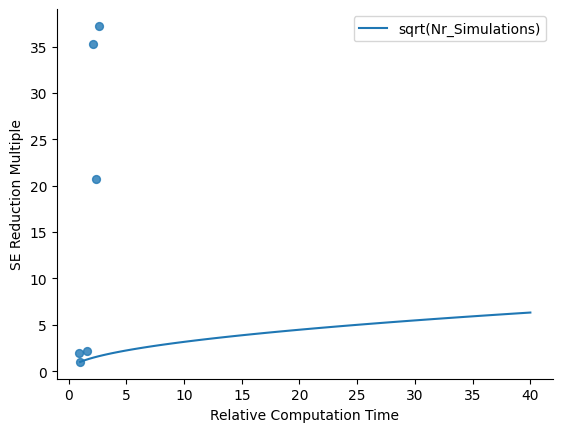

In [ ]:
# @title SE Reduction Multiple vs Relative Computation Time

from matplotlib import pyplot as plt

x = np.linspace(1, 40, 100)
y = np.sqrt(x)

fig = plt.figure(figsize = (10, 5))

df.plot(kind='scatter', x='Relative Computation Time', y='SE Reduction Multiple', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.plot(x, y, label="sqrt(Nr_Simulations)")
plt.legend(loc="upper right")

Simple Monte Carlo simulation with static hedge using the discretely monitored fixed strike geometric average Asian option as a control variate and with antithetic for underlying and volatility

with quasi random numbers

In [ ]:
# Start Timer
start_time = time.time()

# Precompute constants
dt = T/N_tot

# Heston model adjustments for time steps
kappadt = kappa*dt
sigmasdt = sigma*np.sqrt(dt)

# Perform (lower) cholesky decomposition
lower_chol = cholesky(rho, lower=True)

# Generate Wiener variables
Z1 = sobol_norm(m=P, d=N_tot+1).T
Z2 = sobol_norm(m=P, d=N_tot+1).T
W_ind = np.random.normal(size=(N_tot+1,M,1))
#W = Z @ lower_chol
W11 = rho_scalar*Z1 + np.sqrt(1-rho_scalar**2)*Z2
W21 = rho_scalar*Z1 - np.sqrt(1-rho_scalar**2)*Z2
W12 = -rho_scalar*Z1 + np.sqrt(1-rho_scalar**2)*Z2
W22 = -rho_scalar*Z1 - np.sqrt(1-rho_scalar**2)*Z2
# arrays for storing prices and variances
St11 = np.full(shape=(N_tot+1,M), fill_value=S0)
St21 = np.full(shape=(N_tot+1,M), fill_value=S0)
St12 = np.full(shape=(N_tot+1,M), fill_value=S0)
St22 = np.full(shape=(N_tot+1,M), fill_value=S0)
vt1 = np.full(shape=(N_tot+1,M), fill_value=vt0)
vt2 = np.full(shape=(N_tot+1,M), fill_value=vt0)

# array for storing maximum's
AT1_sum = np.full(shape=(M), fill_value=0.0)
AT2_sum = np.full(shape=(M), fill_value=0.0)
AT3_sum = np.full(shape=(M), fill_value=0.0)
AT4_sum = np.full(shape=(M), fill_value=0.0)
GT1_sum = np.full(shape=(M), fill_value=1.0)
GT2_sum = np.full(shape=(M), fill_value=1.0)
GT3_sum = np.full(shape=(M), fill_value=1.0)
GT4_sum = np.full(shape=(M), fill_value=1.0)
finval1 = np.full(shape=(M), fill_value=1.0)
finval2 = np.full(shape=(M), fill_value=1.0)
finval3 = np.full(shape=(M), fill_value=1.0)
finval4 = np.full(shape=(M), fill_value=1.0)



for j in range(N_pre+1,N_tot+1):

    # Simulate variance processes
    vt1[j] = np.maximum(vt1[j-1] + kappadt*(theta - vt1[j-1]) + sigmasdt*np.sqrt(vt1[j-1])*Z1[j-1,:],0)
    vt2[j] = np.maximum(vt2[j-1] + kappadt*(theta - vt2[j-1]) - sigmasdt*np.sqrt(vt2[j-1])*Z1[j-1,:],0)

    # Simulate log asset prices
    nudt1 = (r - div - 0.5*vt1[j-1])*dt
    nudt2 = (r - div - 0.5*vt2[j-1])*dt
    St11[j] = St11[j-1]*np.exp( nudt1 + np.sqrt(vt1[j-1]*dt)*W11[j-1,:] )
    St21[j] = St21[j-1]*np.exp( nudt1 + np.sqrt(vt1[j-1]*dt)*W21[j-1,:] )

    St12[j] = St12[j-1]*np.exp( nudt2 + np.sqrt(vt2[j-1]*dt)*W12[j-1,:] )
    St22[j] = St22[j-1]*np.exp( nudt2 + np.sqrt(vt2[j-1]*dt)*W22[j-1,:] )

    AT1_sum += St11[j]
    AT2_sum += St21[j]
    AT3_sum += St12[j]
    AT4_sum += St22[j]
    GT1_sum = GT1_sum*(St11[j]**(1/N_avg))
    GT2_sum = GT2_sum*(St21[j]**(1/N_avg))
    GT3_sum = GT3_sum*(St12[j]**(1/N_avg))
    GT4_sum = GT4_sum*(St22[j]**(1/N_avg))
    finval1 = St11[j]
    finval2 = St21[j]
    finval3 = St21[j]
    finval4 = St22[j]

#for j in range(1,N_tot+1):

#    # Simulate variance processes
#    vt[j] = vt[j-1] + kappadt*(theta - vt[j-1]) + sigmasdt*np.sqrt(vt[j-1])*W[j-1,:,0]

#    # Simulate log asset prices
#    nudt = (r - div - 0.5*vt[j])*dt
#    St[j] = St[j-1]*np.exp( nudt + np.sqrt(vt[j]*dt)*W[j-1,:,1] )

#    AT_sum += St[j]


# Compute Expectation and SE
#AT_sum = AT_sum/N_tot
AT1_sum = AT1_sum/N_avg
AT2_sum = AT2_sum/N_avg
AT3_sum = AT3_sum/N_avg
AT4_sum = AT4_sum/N_avg
GT1_sum = GT1_sum
GT2_sum = GT2_sum
GT3_sum = GT3_sum
GT4_sum = GT4_sum
CT = 0.25*(np.maximum(0, AT1_sum - K) + np.maximum(0, AT2_sum - K) + np.maximum(0, AT3_sum - K) + np.maximum(0, AT4_sum - K) - np.maximum(0, GT1_sum - K) - np.maximum(0, GT2_sum - K) - np.maximum(0, GT3_sum - K) - np.maximum(0, GT4_sum - K))
CT_geom = 0.25*(np.maximum(0, GT1_sum - K) + np.maximum(0, GT2_sum - K) + np.maximum(0, GT3_sum - K) + np.maximum(0, GT4_sum - K))
CT_call = 0.25*(np.maximum(0, finval1 - K) + np.maximum(0, finval2 - K) + np.maximum(0, finval3 - K) + np.maximum(0, finval4 - K))

C0_av_dbl_cv = np.exp(-r*T)*np.sum(CT)/M
C0_fast_geom = np.exp(-r*T)*np.sum(CT_geom)/M
C0_fast_call = np.exp(-r*T)*np.sum(CT_call)/M

SE_av_dbl_cv = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_av_dbl_cv)**2) / (M-1) ) /np.sqrt(M)
SE_fast_geom = np.sqrt( np.sum( (np.exp(-r*T)*CT_geom - C0_fast_geom)**2) / (M-1) ) /np.sqrt(M)
SE_fast_call = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_fast_call)**2) / (M-1) ) /np.sqrt(M)

C0_av_dbl_cv = C0_av_dbl_cv + 1.0*DiscGeomAsianCall_disc(S0,vt0,theta,sigma,kappa,rho_scalar,r,0,t_n,tauK,0,T,K).real

time_comp_av_dbl_cv = round(time.time() - start_time,4)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_av_dbl_cv,3),np.round(SE_av_dbl_cv,3)))
print("Computation time is: ", time_comp_av_dbl_cv)
print("Geom Call value is ${0} with SE +/- {1}".format(np.round(C0_fast_geom,3),np.round(SE_fast_geom,3)))
print("Normal Call value is ${0} with SE +/- {1}".format(np.round(C0_fast_call,3),np.round(SE_fast_call,3)))

1.9654967915727628e-07
Call value is $5.903 with SE +/- 0.001
Computation time is:  6.123
Geom Call value is $5.638 with SE +/- 0.01
Normal Call value is $10.875 with SE +/- 0.029
